# Water Potability Analysis

Lupe Luna  |  July 12, 2021

## Project Summary

### Overview
 * Acquire the Water Potability dataset
 * Clean and prep the data for exploration and modeling
 * Identify the drivers for water potability
 * Apply machine learning classifiction model to test the dataset

### Goals
 * Identify the key driver for water potability
 * Document code, go through the process and review the takeaways in JupyterLab
 * Summarize the findings in a 5 minute presentation to present within classmates

### Key Takeaways
 * Decision Tree was the best model run  beating the baseline model of .60 and the Decision Tree accuracy score of 0.637

In [96]:
# for presentation purposes
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import prepare
from acquire import get_df

# visualize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.dummy import DummyClassifier

#train test split from sklearn
from sklearn.model_selection import train_test_split
#imputer from sklearn
from sklearn.impute import SimpleImputer

# to evaluate performance using rmse
from sklearn.metrics import mean_squared_log_error, classification_report
from math import sqrt

# for tsa
import statsmodels.api as sm

# holt's linear trend model.
from statsmodels.tsa.api import Holt

# Decision Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Logistic Regression
from sklearn.linear_model import LogisticRegression

### Acquire
 * pull the csv data and see the information that we are working with on the data pulled
 * Completed data summarization (.shape, .describe(), .info())
 * Review the information regarding data types and see if we are missing data by checking for null values
 * Describe the dataset (quick snapshot showing stats on columns w/ numeric data types)
 * Plot a few histograms to get a look at the distribution of some of our variables

In [16]:
# Pull the .csv data from acquire.py
df = get_df()
df.head(3)

,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,,,,,,,,,
NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0


In [17]:
# see how many columns and rows I am working with
df.shape

(3276, 9)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3276 entries, nan to 7.874671357791282
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Hardness         3276 non-null   float64
 1   Solids           3276 non-null   float64
 2   Chloramines      3276 non-null   float64
 3   Sulfate          2495 non-null   float64
 4   Conductivity     3276 non-null   float64
 5   Organic_carbon   3276 non-null   float64
 6   Trihalomethanes  3114 non-null   float64
 7   Turbidity        3276 non-null   float64
 8   Potability       3276 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 255.9 KB


In [19]:
df.describe()

,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


### Prepare

In [20]:
#rename columns (lowercase)
df.columns = map(str.lower, df.columns)

In [21]:
df.head(2)

,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
ph,,,,,,,,,
NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
3.71608,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0


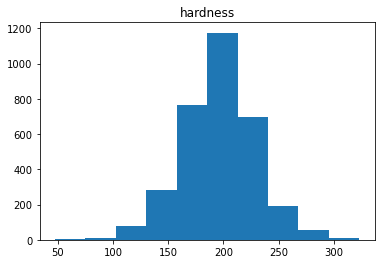

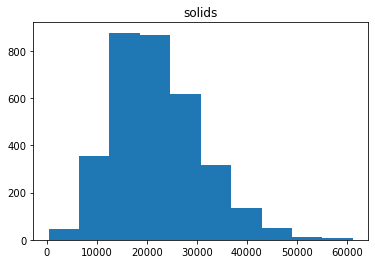

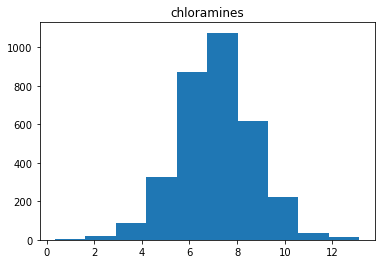

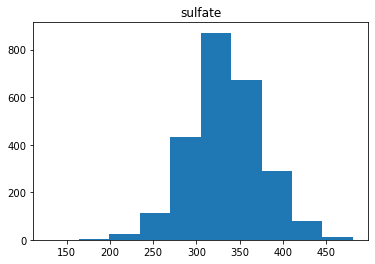

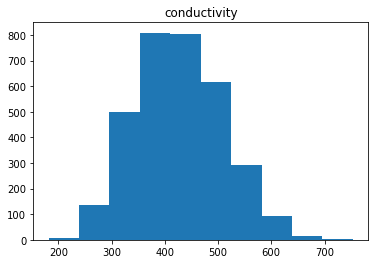

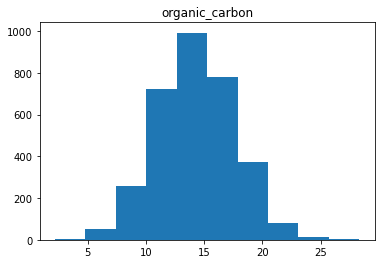

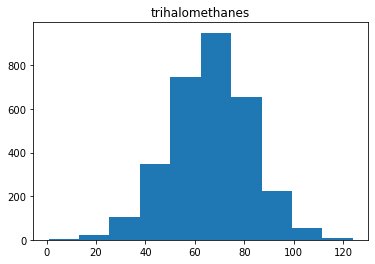

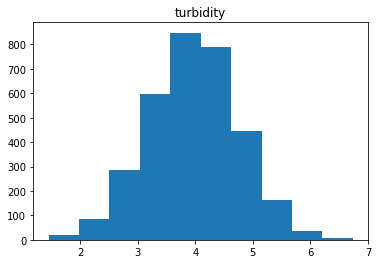

In [22]:
# Check the distributions
num_cols = df.columns[[df[col].dtype == 'float64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [23]:
obj_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]

In [24]:
# describe object columns
for col in obj_cols:
    print(df[col].value_counts())
    print('----------------')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------')

0    1998
1    1278
Name: potability, dtype: int64
----------------
0    0.60989
1    0.39011
Name: potability, dtype: float64
----------------


In [25]:
# missing nulls
missing = df.isnull().sum()
missing[missing > 0]

sulfate            781
trihalomethanes    162
dtype: int64

In [26]:
df.dropna(inplace=True)

In [27]:
df.shape

(2373, 9)

In [28]:
# Baseline 0.596718
df.potability.value_counts(normalize=True)

0    0.602191
1    0.397809
Name: potability, dtype: float64

In [29]:
#. seeing that dropping the nulls did not change much of the 0/1 results

#### Takeways from data
 * potability is my target

### Split

In [30]:
train, validate, test = prepare.split_data(df)

In [31]:
# Validate my split.

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (1328, 9)
validate -> (570, 9)
test -> (475, 9)


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1328 entries, 7.2055591745887275 to 5.412762497595831
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hardness         1328 non-null   float64
 1   solids           1328 non-null   float64
 2   chloramines      1328 non-null   float64
 3   sulfate          1328 non-null   float64
 4   conductivity     1328 non-null   float64
 5   organic_carbon   1328 non-null   float64
 6   trihalomethanes  1328 non-null   float64
 7   turbidity        1328 non-null   float64
 8   potability       1328 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 103.8 KB


In [33]:
train.corr()[['potability']].sort_values(by = 'potability')

,potability
conductivity,-0.077228
sulfate,-0.037892
hardness,-0.026988
organic_carbon,-0.011794
trihalomethanes,-0.007720
chloramines,0.021347
turbidity,0.036061
solids,0.059326
potability,1.000000


In [34]:
# heatmap if time allows

### Explore

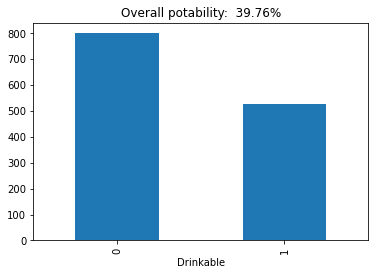

In [99]:
# Univariate 

train.potability.value_counts(normalize=False).plot.bar()

# annotate with the mean value in the title
potability_rate = train.potability.mean()
plt.title(f"Overall potability: {potability_rate: .2%}")
plt.xlabel("Drinkable")
plt.show()

<AxesSubplot:xlabel='potability', ylabel='solids'>

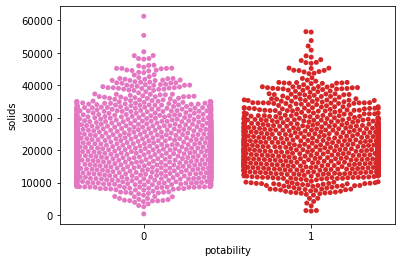

In [162]:
# Bivariate

sns.swarmplot(x=df.potability, y=df.solids, palette='tab10_r')

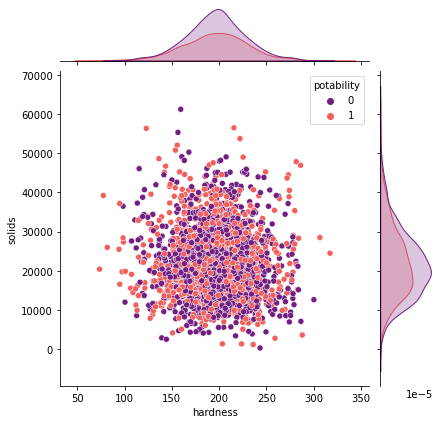

In [146]:
# Multivariate
sns.jointplot(data=df, x="hardness", y="solids", hue="potability", palette='magma')

 * $H_o$: There is no association between solids and potability
 * $H_a$: There is an association between solids and potability

In [35]:
observed = pd.crosstab(train.solids, train.potability, margins=True)
observed

potability,0,1,All
solids,,,
320.942611274359,1,0,1
1351.9069790965912,0,1,1
1372.0910434922284,0,1,1
2808.025755679448,0,1,1
2912.2112468274267,1,0,1
...,...,...,...
50279.262429338494,1,0,1
50793.89891687405,0,1,1
55334.70279929284,1,0,1


In [36]:
# set our alpha
alpha = 0.05

In [39]:
# chi2 contingency return 4 different values
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [40]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[   1    0    1]
 [   0    1    1]
 [   0    1    1]
 ...
 [   1    0    1]
 [   1    0    1]
 [ 800  528 1328]]
---
Expected

[[   0    0    1]
 [   0    0    1]
 [   0    0    1]
 ...
 [   0    0    1]
 [   0    0    1]
 [ 800  528 1328]]
---

chi^2 = 1328.0000
p     = 1.0000


In [41]:
if p < alpha:
    print('We reject the null')
else:
    print("we fail to reject the null")

we fail to reject the null


In [42]:
# tenure with churn t-test

 * $H_o$: There is no association between conductivity and potability
 * $H_a$: There is an association between conductivity and potability

In [43]:
pd.crosstab(train.conductivity, train.potability, margins=True)

potability,0,1,All
conductivity,,,
201.6197367551575,0,1,1
210.31918197203672,1,0,1
251.02089870586465,1,0,1
252.968327784214,1,0,1
254.39327560480754,1,0,1
...,...,...,...
652.5375916144461,1,0,1
656.924127807846,0,1,1
666.6906183307466,1,0,1


In [44]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['potability'])
y_train = train.potability

X_validate = validate.drop(columns=['potability'])
y_validate = validate.potability

X_test = test.drop(columns=['potability'])
y_test = test.potability

In [45]:
X_train.head(3)

,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity
ph,,,,,,,,
7.205559,120.327615,24627.867560,6.202469,289.768697,418.433290,13.643147,63.733732,3.710053
6.901863,164.723486,20442.615014,5.163931,341.537089,468.416350,10.362623,65.694878,4.047907
7.493844,197.331291,26678.392879,7.198435,269.892347,375.503062,13.134917,69.590806,3.819947


### Modeling

In [46]:
# looking for an algorithm that beats the 73% accuracy shown on the value counts
df.potability.value_counts(normalize=True)

0    0.602191
1    0.397809
Name: potability, dtype: float64

In [48]:
# Add baseline model to compare each model below
# Baseline Model
df['baseline_prediction'] = '0'
df.head(3)

,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability,baseline_prediction
ph,,,,,,,,,,
NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0,0
8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0,0
9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,0


In [49]:
df[['baseline_prediction', 'potability']]

,baseline_prediction,potability
ph,,
NaN,0,0
8.316766,0,0
9.092223,0,0
5.584087,0,0
10.223862,0,0
...,...,...
8.989900,0,1
6.702547,0,1
11.491011,0,1


In [51]:
len(df[df.baseline_prediction != df.potability][['baseline_prediction', 'potability']])/len(df)

1.0

In [58]:
baseline = DummyClassifier(strategy='constant', constant=0)

In [62]:
#Fit the object
baseline.fit(X_train, y_train)

DummyClassifier(constant=0, strategy='constant')

In [63]:
baseline_accuracy = baseline.score(X_train, y_train)
baseline_accuracy

0.6024096385542169

### Decision Tree

In [65]:
train.corr()[['potability']].sort_values(by = 'potability')

,potability
conductivity,-0.077228
sulfate,-0.037892
hardness,-0.026988
organic_carbon,-0.011794
trihalomethanes,-0.007720
chloramines,0.021347
turbidity,0.036061
solids,0.059326
potability,1.000000


In [64]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [66]:
type(clf)

sklearn.tree._classes.DecisionTreeClassifier

In [67]:
# model.fit(X, y)
clf = clf.fit(X_train, y_train)

In [68]:
type(clf)

sklearn.tree._classes.DecisionTreeClassifier

In [69]:
# visualize decision tree

In [70]:
y_pred = clf.predict(X_train)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [71]:
type(y_pred)

numpy.ndarray

In [72]:
# changing a numpy array to a series

pd.Series(y_pred[0:5])

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [73]:
pd.DataFrame(y_pred[0:5])

,0
0,0
1,0
2,0
3,0
4,0


In [74]:
y_pred.mean()

0.03765060240963856

In [75]:
accuracy_df = pd.DataFrame(y_pred)
accuracy_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
1323,0
1324,0
1325,0
1326,0


In [76]:
accuracy_df['potability'] = y_train.reset_index(drop=True)
accuracy_df

,0,potability
0,0,0
1,0,0
2,0,1
3,0,0
4,0,1
...,...,...
1323,0,0
1324,0,1
1325,0,0
1326,0,0


In [77]:
# manual version of the clf.score
(accuracy_df[0] == accuracy_df['potability']).mean()

0.6370481927710844

In [78]:
clf.score(X_train, y_train)

0.6370481927710844

In [79]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.64


[Text(357.12, 448.47, 'sulfate <= 260.92\ngini = 0.479\nsamples = 1328\nvalue = [800, 528]\nclass = solids'),
 Text(178.56, 366.93, 'solids <= 21161.408\ngini = 0.397\nsamples = 55\nvalue = [15, 40]\nclass = potability'),
 Text(89.28, 285.39, 'gini = 0.391\nsamples = 15\nvalue = [11, 4]\nclass = solids'),
 Text(267.84000000000003, 285.39, 'gini = 0.18\nsamples = 40\nvalue = [4, 36]\nclass = potability'),
 Text(535.6800000000001, 366.93, 'hardness <= 115.1\ngini = 0.473\nsamples = 1273\nvalue = [785, 488]\nclass = solids'),
 Text(446.4, 285.39, 'gini = 0.32\nsamples = 15\nvalue = [3, 12]\nclass = potability'),
 Text(624.96, 285.39, 'conductivity <= 371.036\ngini = 0.47\nsamples = 1258\nvalue = [782, 476]\nclass = solids'),
 Text(535.6800000000001, 203.84999999999997, 'gini = 0.496\nsamples = 349\nvalue = [191, 158]\nclass = solids'),
 Text(714.24, 203.84999999999997, 'sulfate <= 292.42\ngini = 0.455\nsamples = 909\nvalue = [591, 318]\nclass = solids'),
 Text(624.96, 122.31, 'solids <= 1

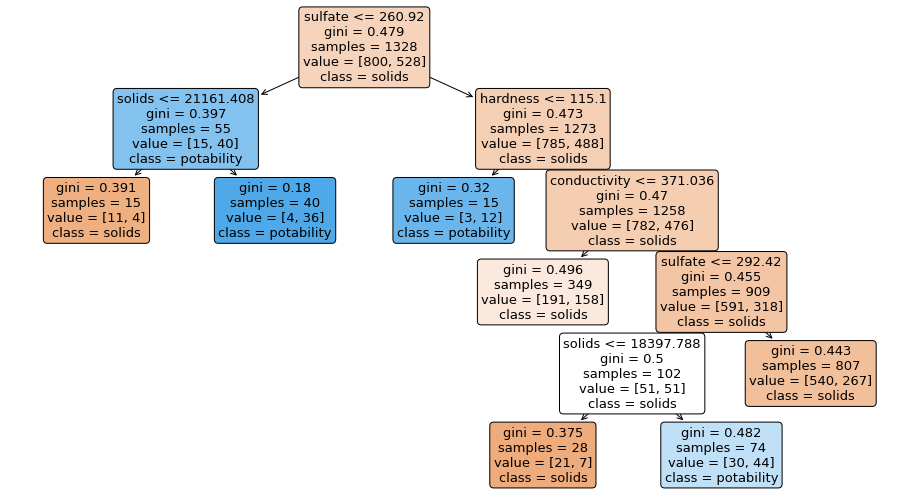

In [83]:
model = DecisionTreeClassifier(max_leaf_nodes=7)
model.fit(X_train, y_train)

plt.figure(figsize=(16, 9))
plot_tree(model, feature_names=X_train.columns.tolist(), class_names=['solids', 'potability'], filled=True, rounded=True)

In [84]:
pd.Series(dict(zip(X_train.columns, model.feature_importances_)))

hardness           0.125962
solids             0.324478
chloramines        0.000000
sulfate            0.421952
conductivity       0.127608
organic_carbon     0.000000
trihalomethanes    0.000000
turbidity          0.000000
dtype: float64

<AxesSubplot:ylabel='Feature Importance'>

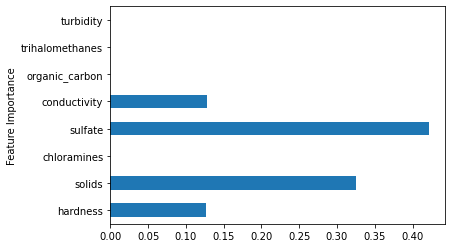

In [85]:
pd.Series(dict(zip(X_train.columns, model.feature_importances_))).plot.barh(xlabel='Feature Importance')

### Logistic Regression

In [86]:
train.corr()[['potability']].sort_values(by = 'potability')

,potability
conductivity,-0.077228
sulfate,-0.037892
hardness,-0.026988
organic_carbon,-0.011794
trihalomethanes,-0.007720
chloramines,0.021347
turbidity,0.036061
solids,0.059326
potability,1.000000


In [91]:
# Create the logistic regression model using solids, conductivity, sulfate
logit = LogisticRegression(random_state=123)

# specify the features we're using
features = ["conductivity", "sulfate", "hardness"]

# Fit a model using only these specified features
# logit.fit(X_train[["age", "pclass", "fare"]], y_train)
logit.fit(X_train[features], y_train)

# Since we .fit on a subset, we .predict on that same subset of features
y_pred = logit.predict(X_train[features])

print("Baseline is", round(baseline_accuracy, 2))
print("Logistic Regression using age, pclass, and fare features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train[features], y_train)))

Baseline is 0.6
Logistic Regression using age, pclass, and fare features
Accuracy of Logistic Regression classifier on training set: 0.60


In [90]:
# Create the logistic regression
logit1 = LogisticRegression(random_state=123)

# specify the features we're using
features = ["solids", "conductivity", "turbidity"]

# Fit a model using only these specified features
logit1.fit(X_train[features], y_train)

y_pred = logit1.predict(X_train[features])

print("Logistic Regression using age, pclass, fare, and gender features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train[features], y_train)))

Logistic Regression using age, pclass, fare, and gender features
Accuracy of Logistic Regression classifier on training set: 0.60


In [92]:
# Now pick the best models and evaluate on Validate!

In [93]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.64


In [94]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.61


In [97]:
# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.99      0.75       343
           1       0.69      0.04      0.07       227

    accuracy                           0.61       570
   macro avg       0.65      0.51      0.41       570
weighted avg       0.64      0.61      0.48       570

